In [17]:
import nibabel
import nibabel.affines
from PIL import Image
import os
import fnmatch
import numpy as np
import ants
import scipy.io as sio
import pickle
import concurrent.futures

np.set_printoptions(precision=2, suppress=True)

## File handling and loading functions

In [18]:
# Load an image into nibabel
def load_image(data_path, filename):
    
    return nibabel.load(f"{data_path}/{filename}")

# Display the middle slice of a nibabel image
def display_image(image):

    # Get image data array from image object
    image_array = np.asarray(image.dataobj)
    
    # Get middle slice
    slice = image_array[image_array.shape[0] // 2, :, :]
    
    # Scale the image such that the maximum pixel value is 255
    # Display the scaled image
    display(Image.fromarray(((slice / np.max(slice)) * 255).astype(np.uint8)))
    
    return 

# Display the middle slice of a 3d array
def display_array(array):
    
    # Get middle slice
    slice = array[array.shape[0] // 2, :, :]
    
    # Scale the image such that the maximum pixel value is 255
    # Display the scaled image
    display(Image.fromarray(((slice / np.max(slice)) * 255).astype(np.uint8)))
    
    return 

# Find files with a specific filename and return a list. Non-recursive 
def list_files_ext(data_path, extensions):

    files = [f for f in os.listdir(data_path) if f.endswith(extensions)]
        
    return files       

# Return the absolute path to all files matching a filename in a directory. Recursive
def list_files_fname(data_path, filename):
    
    matched_files = []
    
    for root, dirs, files in os.walk(data_path):
        
        for file in fnmatch.filter(files, filename):
            
            matched_files.append(os.path.join(root, file))
    
    return matched_files


## Image manipulation functions

In [19]:
# Returns a dictionary of subjects with their orig_nu.mgz, mask.mgz, and subj_dir paths
def get_dict(data_path):
    
    dict = {}

    for item in os.listdir(data_path):
        
        subject_path = os.path.join(data_path, item)
        
        if os.path.isdir(subject_path):
            
            # MRI directory of subject path
            mri_path = os.path.join(subject_path, 'mri')
            
            # Check for MRI directory
            if os.path.isdir(mri_path):
                
                orig_file = os.path.join(mri_path, 'orig_nu.mgz')
                
                mask_file = os.path.join(mri_path, 'mask.mgz')

                # If both orig.mgz and mask.mgz exist, add them to the dictionary
                if os.path.isfile(orig_file) and os.path.isfile(mask_file):
                    
                    dict[item] = {'orig': orig_file, 'mask': mask_file, 'subj_dir': subject_path}

    return dict

# Performs brain extraction using the orig_nu.mgz and mask.mgz of the subject by multiplying the mask with the image
def extract_brain(orig_file, mask_file):
    
    # Load the image and the brain mask
    image = nibabel.load(orig_file)
    mask = nibabel.load(mask_file)
    
    # Get their image arrays
    image_array = np.asarray(image.dataobj)
    mask_array = np.asarray(mask.dataobj)
    
    # Apply the mask, the mask entries are 1 or 0
    brain_array = image_array * mask_array
    
    return brain_array

### Reference brain (global)

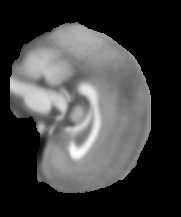

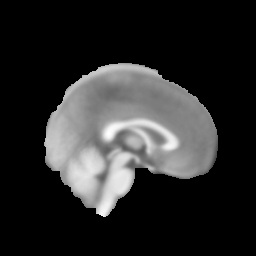

In [20]:
# NB seems that fastsrufer brain is better
reference_brain_array_mni = extract_brain("/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/icbm_avg_152_t1_tal_lin.nii", "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/icbm_avg_152_t1_tal_lin_mask.nii")

display_array(reference_brain_array_mni)

reference_brain_array_fastsurfer = extract_brain("/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/fastsurfer-processed/mri/orig_nu.mgz", "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/fastsurfer-processed/mri/mask.mgz")

display_array(reference_brain_array_fastsurfer)


### Affine alignment

In [21]:
# Function for affine registration and saving the transformation
def affine_alignment(subject_data):

    # Extract brain of subject and convert it to an ANTsPy image
    # The subject's brain is the moving image
    brain_array = extract_brain(subject_data['orig'], subject_data['mask'])
    
    moving_image = ants.from_numpy(brain_array)
    
    # Convert the reference brain to an ANTsPy image
    # The reference brain is already extracted
    fixed_image = ants.from_numpy(reference_brain_array_fastsurfer)
    
    # Perform registration using ANTsPy
    registration = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform='AffineFast')
    
    aligned_brain_array = registration['warpedmovout'].numpy()
    
    # Load the .mat file containing the transformation
    transformation = sio.loadmat(registration['fwdtransforms'][0])
    
    # Save the transformation to a pickle file
    with open(os.path.join(subject_data['subj_dir'], 'affine_alignment.pkl'), 'wb') as file:
        pickle.dump(transformation, file)
    
    # Make nibabel image from array
    # Identity matrix as affine transform
    aligned_image = nibabel.Nifti1Image(aligned_brain_array, np.eye(4))
    
    # Save the NiBabel image as a .nii file
    aligned_image_path = os.path.join(subject_data['subj_dir'], 'aligned_brain.nii')
    
    nibabel.save(aligned_image, aligned_image_path)
    
    return aligned_image

### Cropping

In [22]:
def bounding_box(image_array):
    
    non_zero_indices = np.nonzero(image_array)
    
    min_x, min_y, min_z = np.min(non_zero_indices[0]), np.min(non_zero_indices[1]), np.min(non_zero_indices[2])
    max_x, max_y, max_z = np.max(non_zero_indices[0]), np.max(non_zero_indices[1]), np.max(non_zero_indices[2])
    
    return (min_x, min_y, min_z, max_x, max_y, max_z)

def crop_array(image_array, bounding_box, border_size=2):

    min_x, min_y, min_z, max_x, max_y, max_z = bounding_box
    
    min_x = max(min_x - border_size, 0)
    min_y = max(min_y - border_size, 0)
    min_z = max(min_z - border_size, 0)
    
    max_x = min(max_x + border_size, image_array.shape[0] - 1)
    max_y = min(max_y + border_size, image_array.shape[1] - 1)
    max_z = min(max_z + border_size, image_array.shape[2] - 1)
    
    return image_array[min_x:max_x+1, min_y:max_y+1, min_z:max_z+1]
    

## Main code

In [23]:
data_path = ""

# List of masks
fpath_list = list_files_fname(data_path, "mask.mgz")

# Number of masks
print(f"{len(fpath_list)}\n")


1



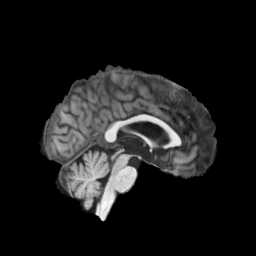

In [24]:
subj_dict = get_dict(data_path)
    
# Use ProcessPoolExecutor to run affine alignment in parallel
with concurrent.futures.ProcessPoolExecutor() as executor:
    
    futures = []
    
    for subject_key, subject_data in subj_dict.items():

        futures.append(executor.submit(affine_alignment, subject_data))
    
    for future in concurrent.futures.as_completed(futures):
        
        display_image(future.result())

In [25]:
subj_dict = get_dict(data_path)

max_bbox = (np.inf, np.inf, np.inf, -np.inf, -np.inf, -np.inf)

for subject_key, subject_data in subj_dict.items():
    
    image = nibabel.load(os.path.join(subject_data['subj_dir'], 'aligned_brain.nii'))
    
    min_x, min_y, min_z, max_x, max_y, max_z = bounding_box(image.get_fdata())
    
    global_min_x, global_min_y, global_min_z, global_max_x, global_max_y, global_max_z = max_bbox
    
    max_bbox = (
        min(global_min_x, min_x),
        min(global_min_y, min_y),
        min(global_min_z, min_z),
        max(global_max_x, max_x),
        max(global_max_y, max_y),
        max(global_max_z, max_z)
    )
    
    print(max_bbox)
    
print(max_bbox)

(np.int64(55), np.int64(60), np.int64(35), np.int64(201), np.int64(221), np.int64(220))
(np.int64(55), np.int64(60), np.int64(35), np.int64(201), np.int64(221), np.int64(220))


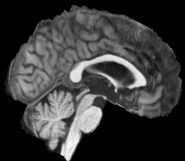

In [26]:
for subject_key, subject_data in subj_dict.items():
    
    image = nibabel.load(os.path.join(subject_data['subj_dir'], 'aligned_brain.nii'))
    
    image_array = image.get_fdata()
    
    global_min_x, global_min_y, global_min_z, global_max_x, global_max_y, global_max_z = max_bbox
    
    # Crop the image array using the global bounding box
    cropped_array = image_array[
        int(global_min_x):int(global_max_x),
        int(global_min_y):int(global_max_y),
        int(global_min_z):int(global_max_z)
    ]
    
    # Create a new NiBabel image from the cropped array
    cropped_image = nibabel.Nifti1Image(cropped_array, image.affine)
    
    display_image(cropped_image)
    
    # Overwrite the original image by saving the cropped image back to the same path
    nibabel.save(cropped_image, os.path.join(subject_data['subj_dir'], 'aligned_brain_cropped.nii'))
    
    

Todo:
- Crop images to reduce the size of 3d CNN (could crop to the boundaries of the max brain after registration)
- Load XML disease label and store with image. NB could implement a class that stores various image data
- Start training NN

NB no need for intensity normalisation this is already done by freesurfer/fastsurfer